In [104]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import softmax
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import tensorflow as tf
from tqdm.notebook import tqdm, trange

In [106]:
rng = np.random.default_rng(seed=1234)

data = tf.keras.datasets.mnist.load_data()
(train_images, train_labels), (test_images, test_labels) = data
train_images, test_images = train_images / 255, test_images / 255

kernel_size = 5
num_images = 3000
minibatch_size = 100
num_filters = 16
num_hidden_units = 100

In [107]:
def out_size(img_width, img_height, kernel_size, pad=0, stride=1):
    out_width = (img_width + 2 * pad - kernel_size) // stride + 1
    out_height = (img_height + 2 * pad - kernel_size) // stride + 1
    
    return out_width, out_height

def conv2d_patches(img, kernel_size=5, pad=0, stride=1):
    img_width, img_height = img.shape[-2:]
    out_width, out_height = out_size(
        img_width, img_height, kernel_size, pad, stride,
    )

    pad_width = *((0, 0),)*(img.ndim - 2), (pad, pad), (pad, pad)
    padded_img = np.pad(img, pad_width)

    patches_shape = (out_width, out_height, kernel_size, kernel_size)
    out = np.empty(img.shape[:-2] + patches_shape)
    for x in range(out_width):
        for y in range(out_height):
            x_slice = slice(stride * x, stride * x + kernel_size)
            y_slice = slice(stride * y, stride * y + kernel_size)
            out[..., x, y, :, :] = padded_img[..., x_slice, y_slice]
    
    return out

In [109]:
class SparseCodingLayer:
    
    def __init__(self, num_inputs, num_filters, seed=1234):
        self.num_filters = num_filters

        rng = np.random.default_rng(seed=seed)
        self.exc_weights = rng.uniform(size=(num_filters, num_inputs))
        self.inh_weights = np.zeros((num_filters, num_filters))
        self.thresholds = np.full(num_filters, fill_value=5.0)
        
        self.alpha = 0.0001  # excitatory weight learning rate
        self.beta = 0.01  # inhibitory weight learning rate
        self.gamma = 0.02  # threshold adjustment rate
        self.rho = 0.05  # average spike rate
        
    def present(self, inputs, num_steps=20):
        # initialize neurons
        membrane_potential = np.zeros(self.num_filters)
        spikes = np.zeros((num_steps + 1, self.num_filters), dtype=bool)
        
        # the first part is the same each loop, so we precompute it for performance
        exc_potential = self.exc_weights @ inputs
        for step in range(1, num_steps + 1):
            membrane_potential += exc_potential
            membrane_potential -= self.inh_weights @ spikes[step - 1]
            
            spikes[step] = membrane_potential >= self.thresholds
            membrane_potential *= ~spikes[step]
        
        self._train(inputs, spikes)

    def _train(self, inputs, spikes):
        # apply learning rules
        n_i = spikes.sum(axis=0)        

        self.exc_weights += self.alpha * np.outer(n_i, inputs - n_i @ self.exc_weights)
        
        self.inh_weights += self.beta * (np.outer(n_i, n_i) - self.rho**2)
        self.inh_weights[np.diag_indices_from(self.inh_weights)] = 0

        self.thresholds += self.gamma * (n_i - self.rho)
    
sc_layer = SparseCodingLayer(
    num_inputs=kernel_size**2,
    num_filters=num_filters,
)

patch_images = (train_images - train_images.mean()) / train_images.std()
patches = conv2d_patches(patch_images[:num_images], kernel_size=kernel_size)
patches = patches.reshape(-1, kernel_size**2)
patches = patches[rng.permutation(patches.shape[0])]
for patch in tqdm(patches):
    sc_layer.present(patch)

  0%|          | 0/1728000 [00:00<?, ?it/s]

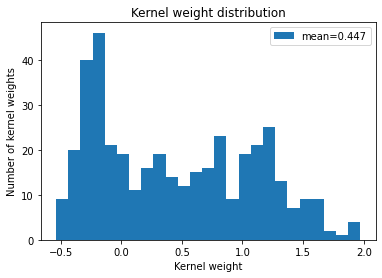

In [110]:
kernel_weights = sc_layer.exc_weights.reshape(-1, kernel_size, kernel_size)
#kernel_weights -= kernel_weights.mean()
plt.hist(kernel_weights.flatten(), bins=25, label=f'mean={kernel_weights.mean():.3f}')
plt.title('Kernel weight distribution')
plt.xlabel('Kernel weight')
plt.ylabel('Number of kernel weights')
plt.legend()
plt.show()

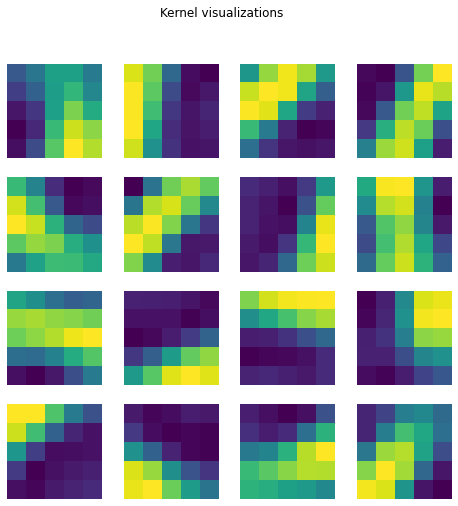

In [111]:
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in zip(range(num_filters), axs.flatten()):
    ax.imshow(kernel_weights[i], interpolation=None)
    ax.axis('off')
fig.suptitle('Kernel visualizations')
plt.show()

In [112]:
class SpikeLayer:

    def present(self, inputs, num_steps=20):
        # initialize neurons
        membrane_potential = np.zeros_like(inputs)
        spikes = np.zeros((num_steps,) + inputs.shape, dtype=bool)

        for step in range(num_steps):
            membrane_potential += inputs
            spikes[step] = membrane_potential >= 1
            membrane_potential -= inputs * spikes[step]
        
        return spikes
    
pixel_spike_layer = SpikeLayer()
pixel_spikes = pixel_spike_layer.present(train_images[:minibatch_size])

In [113]:
class Conv2DLayer:
    
    def __init__(self, kernel_weights):
        self.kernel_weights = kernel_weights  # 16, 5, 5
        self.num_kernels = self.kernel_weights.shape[0]
        self.kernel_size = kernel_weights.shape[-1]
        
    def present(self, pixel_spikes, num_steps=20):
        out_width, out_height = out_size(*pixel_spikes.shape[-2:], self.kernel_size)
        membrane_potential = np.zeros(
            pixel_spikes.shape[1:-2] + (self.num_kernels, out_width, out_height)
        )
        spikes = np.zeros((num_steps,) + membrane_potential.shape, dtype=bool)

        patches = conv2d_patches(pixel_spikes, self.kernel_size)  # *, 24, 24 5, 5
        patch_spikes = np.einsum('kwh,...rcwh->...krc', self.kernel_weights, patches)
        for step in range(num_steps):
            membrane_potential += patch_spikes[step]
            spikes[step] = membrane_potential >= 1
            membrane_potential *= ~spikes[step]
        
        return spikes
    
conv_layer = Conv2DLayer(kernel_weights)
conv_spikes = conv_layer.present(pixel_spikes)

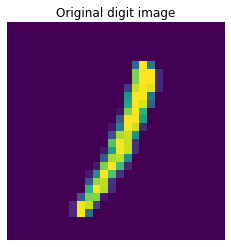

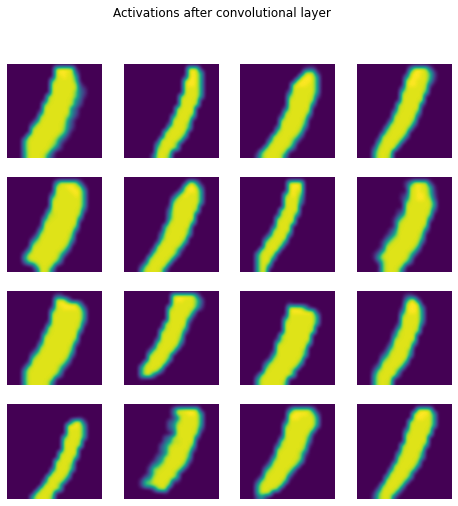

In [114]:
img_idx = 99
plt.imshow(train_images[img_idx])
plt.title('Original digit image')
plt.axis('off')
plt.show()

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in zip(range(16), axs.flatten()):
    ax.imshow(conv_spikes.mean(0)[img_idx, i], interpolation='bicubic')
    ax.axis('off')
fig.suptitle('Activations after convolutional layer')
plt.show()

In [115]:
class Pool2DLayer:

    def present(self, conv_spikes):
        # determine output shape
        out_width, out_height = np.array(conv_spikes.shape[-2:]) // 2
        out_shape = conv_spikes.shape[:-2] + (out_width, out_height)

        # get 2x2 non-overlapping patches of conv spikes
        conv_patches = conv2d_patches(conv_spikes, kernel_size=2, stride=2)
        conv_patches = conv_patches.reshape(out_shape + (4,))

        # get index arrays to take spikes with maximum rate
        index_arrays = self._index_arrays(out_shape)
        max_indices = conv_patches.sum(0).argmax(-1).reshape(-1)
        max_indices = np.tile(max_indices, conv_spikes.shape[0])

        # take spikes with maximum rate and reshape
        pool_spikes = conv_patches[index_arrays + (max_indices,)]
        pool_spikes = pool_spikes.reshape(out_shape)
        
        return pool_spikes

    def _index_arrays(self, shape):
        nelem, ncomb = np.prod(shape), 1
        index_arrays = []
        for dim in range(len(shape)):
            nelem //= shape[dim]
            index_array = np.repeat(range(shape[dim]), nelem)
            index_array = np.tile(index_array, ncomb)
            ncomb *= shape[dim]

            index_arrays.append(index_array)

        return tuple(index_arrays)

pool_layer = Pool2DLayer()
pool_spikes = pool_layer.present(conv_spikes)

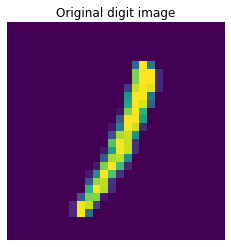

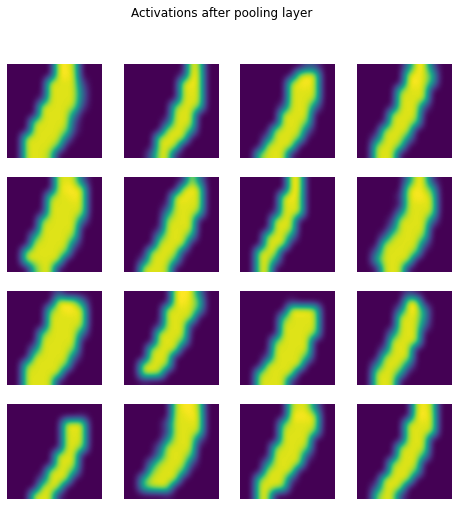

In [116]:
img_idx = 99
plt.imshow(train_images[img_idx])
plt.title('Original digit image')
plt.axis('off')
plt.show()

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in zip(range(16), axs.flatten()):
    ax.imshow(pool_spikes.mean(0)[img_idx, i], interpolation='bicubic')
    ax.axis('off')
fig.suptitle('Activations after pooling layer')
plt.show()

In [123]:
class STDPLayer:

    def __init__(self, num_inputs, num_outputs, seed=1234):
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs        
        
        self.a_plus = 0.001  # long-term potentiation constant
        self.a_minus = 0.00075  # long-term depression constant
        self.eps = 5  # maximum time difference for LTP        
        
        rng = np.random.default_rng(seed=seed)
        self.weights = rng.uniform(size=(num_outputs, num_inputs))
        self.pre_spikes = np.zeros((self.eps, num_inputs), dtype=bool)

    def present(self, inputs, train=True):        
        # initialize neurons
        num_steps = inputs.shape[0]
        membrane_potential = np.zeros(inputs.shape[1:-1] + (self.num_outputs,))
        accumulated_membrane_potential = np.zeros_like(membrane_potential)
        spikes = np.zeros((num_steps,) + membrane_potential.shape, dtype=bool)

        input_current = np.einsum('hi,...i->...h', self.weights, inputs)
        spike_probs = softmax(input_current, axis=-1)
        for step in range(num_steps):
            membrane_potential += input_current[step]
            accumulated_membrane_potential += input_current[step]
            spikes[step] = (membrane_potential >= 0.5) & (spike_probs[step] >= 0.5)
            membrane_potential *= ~spikes[step]
            
            if train:
                self._train(spikes[step], inputs[step])

        return accumulated_membrane_potential
        
    def _train(self, post_spikes, pre_spikes):
        self.pre_spikes = np.concatenate((
            self.pre_spikes[1:],
            pre_spikes[np.newaxis],
        ))
        ltp = np.any(self.pre_spikes, axis=0) * self.a_plus * np.exp(-self.weights)
        ltd = ~np.any(self.pre_spikes, axis=0) * self.a_minus
        self.weights += post_spikes[:, np.newaxis] * (ltp - ltd)


in_width, in_height = out_size(
    train_images[0].shape[-2], train_images[0].shape[-1],
    kernel_size=kernel_size, stride=2,
)
in_size = num_filters * in_width * in_height
stdp_layer = STDPLayer(in_size, num_hidden_units)
stdp_layer.weights = weights

# for i in trange(0, num_images, minibatch_size):
#     pixel_spikes = pixel_spike_layer.present(train_images[i:i + minibatch_size])
#     conv_spikes = conv_layer.present(pixel_spikes)
#     pool_spikes = pool_layer.present(conv_spikes)
#     pool_spikes = pool_spikes.reshape(pool_spikes.shape[:2] + (-1,))
#     for j in range(pool_spikes.shape[1]):
#         stdp_layer.present(pool_spikes[:, j])

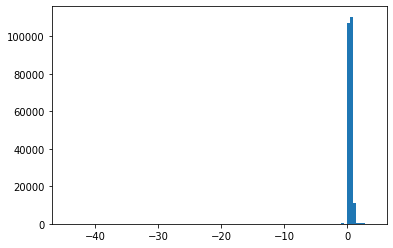

In [197]:
weights[np.unravel_index(weights.argmax(), weights.shape)] = 0
plt.hist(weights.flatten(), bins=100)
plt.show()

In [132]:
weights.argmax()

32496

In [124]:
X, y = [], []
for i in trange(0, num_images, minibatch_size):    
    pixel_spikes = pixel_spike_layer.present(train_images[i:i + minibatch_size])
    conv_spikes = conv_layer.present(pixel_spikes)
    pool_spikes = pool_layer.present(conv_spikes)
    pool_spikes = pool_spikes.reshape(pool_spikes.shape[:2] + (-1,))
    out_features = stdp_layer.present(pool_spikes, train=False)
    
    X.append(out_features)
    y.append(train_labels[i:i + minibatch_size])

svm = SVC()
svm.fit(np.concatenate(X), np.concatenate(y))
preds = svm.predict(np.concatenate(X))

print('accuracy:', accuracy_score(np.concatenate(y), preds))

  0%|          | 0/30 [00:00<?, ?it/s]

accuracy: 0.117
